In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
##################################################################################
##### Define all parameters for model tuning
##################################################################################

n_fold = 5
expName = "NT_Site_PredNTS_Classification_DLNN_CORENup_v2_TrainStrat_2_mySOTA"
outPath = "Results"
foldName = "folds.pickle"

epochs = 100
batch_size = 64
shuffle = True
seed = None

input_data_folder = "Data"
training_data_file = "Training-datasets-PredNTS.txt"
independent_data_file = "independent dataset-PredNTS.txt"

In [3]:
import os 
import pickle
import numpy as np
import pandas as pd

import tensorflow as tf

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, confusion_matrix
from sklearn.metrics import roc_auc_score, matthews_corrcoef, classification_report

import math

import matplotlib.pyplot as plt

In [4]:
# print(tf.test.is_gpu_available(cuda_only=True))
# physical_devices = tf.config.experimental.list_physical_devices('GPU')
physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)
tf.config.experimental.set_memory_growth(physical_devices[0], True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
##################################################################################
##### define all CUSTOM functions
##################################################################################

def one_hot_encode_nt(sequence, char_dict):
    
    seq_encoded = np.zeros((len(sequence),len(char_dict)))
    
    i = 0
    for single_character in sequence:
        if(single_character.upper() in char_dict.keys()):
            seq_encoded[i][char_dict[single_character.upper()]] = 1
            i = i+1
        else:
            raise ValueError('Incorrect character in NT sequence: '+sequence)
    return seq_encoded

In [6]:
##################################################################################
##### Build k-fold functions
##################################################################################

## Build the K-fold from dataset
def build_kfold(features, labels, k=10, shuffle=False, seed=None):
    
    skf = StratifiedKFold(n_splits=k, shuffle=shuffle, random_state=seed)
    kfoldList = []
    for train_index, test_index in skf.split(features, labels):
        X_train, X_test = features[train_index], features[test_index]
        y_train, y_test = labels[train_index], labels[test_index]
        kfoldList.append({
            "X_train": X_train,
            "X_test": X_test,
            "y_train":y_train,
            "y_test":y_test
        })
    return kfoldList



In [7]:
##################################################################################
##### define evaluator functions
##################################################################################

def pred2label(y_pred):
    y_pred = np.round(y_pred)
    return y_pred

def labels_1d_to_2d(labels_1d):
    labels_2d = np.eye(2)[labels_1d]
    return labels_2d

# Model

In [8]:
##################################################################################
##### Function to customize the DLNN architecture with parameters
##################################################################################

def DLNN_CORENup(input_seq_shape = (41, 21),
                 conv_filters_per_layer_1 = 50, kernel_length_1 = 5, conv_strides_1 = 1, ## 1st Convolutional layer parameters
                 max_pool_width_1 = 2, max_pool_stride_1 = 2, ## 1st Maxpool layer parameters
                 lstm_decode_units = 50, ## LSTM layer parameters
                 conv_filters_per_layer_2 = 50,  kernel_length_2 = 10, conv_strides_2 = 1, ## 2nd Convolutional layer parameters
                 max_pool_width_2 = 2, max_pool_stride_2 = 2, ## 2nd Maxpool layer parameters
                 dense_decode_units = 370, ## Dense layer parameters
                 prob = 0.5, learn_rate = 0.0003, loss = 'binary_crossentropy', metrics = None):
    
    beta = 0.001
    
    ######################################################################################################
    ########  SEQUENCE  ##################################################################################
    ######################################################################################################
    
    input1 = tf.keras.layers.Input(shape=input_seq_shape)

    x1 = tf.keras.layers.Conv1D(conv_filters_per_layer_1, kernel_length_1,
                                strides = conv_strides_1, 
                                kernel_regularizer = tf.keras.regularizers.l2(beta), 
                                padding = "same")(input1)
    x1 = tf.keras.layers.Activation('relu')(x1)
    x1 = tf.keras.layers.MaxPool1D(pool_size = max_pool_width_1, strides = max_pool_stride_1)(x1)
    x1 = tf.keras.layers.Dropout(prob)(x1)

    ## LSTM Path

    x2 = tf.keras.layers.LSTM(lstm_decode_units, return_sequences = True, 
                              kernel_regularizer = tf.keras.regularizers.l2(beta))(x1)
    x2 = tf.keras.layers.Dropout(prob)(x2)
    
    x2 = tf.keras.layers.Flatten()(x2)

    ## Conv Path

    x3 = tf.keras.layers.Conv1D(conv_filters_per_layer_2, kernel_length_2, 
                                strides = conv_strides_2, 
                                kernel_regularizer = tf.keras.regularizers.l2(beta), 
                                padding = 'same')(x1)
    x3 = tf.keras.layers.Activation('relu')(x3)
    x3 = tf.keras.layers.MaxPooling1D(pool_size = max_pool_width_2, strides = max_pool_stride_2)(x3)
    x3 = tf.keras.layers.Dropout(prob)(x3)
    
    x3 = tf.keras.layers.Flatten()(x3)
    
    x4 = tf.keras.layers.Concatenate(1)([x2,x3])
    
    ######################################################################################################
    ########  Classifier  ################################################################################
    ######################################################################################################
    
    y = tf.keras.layers.Dense(dense_decode_units, 
                              kernel_regularizer = tf.keras.regularizers.l2(beta), 
                              activation = 'relu')(x4)
    
    y = tf.keras.layers.Dropout(prob)(y)
    
    y = tf.keras.layers.Dense(1, 
                              kernel_regularizer = tf.keras.regularizers.l2(beta), 
                              activation = 'sigmoid')(y)

    ## Generate Model from input and output
    model = tf.keras.models.Model(inputs=input1, outputs=y)
    
    ## Compile model
    if(metrics != None):
        model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=learn_rate), 
                      loss = loss, metrics = metrics)
    else:
        model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=learn_rate), 
                      loss = loss)

    return model

In [9]:
# ##################################################################################
# ##### Function to customize the DLNN architecture with parameters
# ##################################################################################

# def DLNN_CORENup(input_seq_shape = (41, 21),
#                  conv_filters_per_layer_1 = 10, kernel_length_1 = 10, conv_strides_1 = 1, ## 1st Convolutional layer parameters
#                  max_pool_width_1 = 3, max_pool_stride_1 = 3, ## 1st Maxpool layer parameters
#                  lstm_decode_units = 10, ## LSTM layer parameters
#                  conv_filters_per_layer_2 = 10,  kernel_length_2 = 5, conv_strides_2 = 1, ## 2nd Convolutional layer parameters
#                  max_pool_width_2 = 3, max_pool_stride_2 = 3, ## 2nd Maxpool layer parameters
#                  dense_decode_units = 32, ## Dense layer parameters
#                  prob = 0.5, learn_rate = 0.0005, 
#                  loss = 'binary_crossentropy', metrics = None):
    
#     beta = 0.001
    
#     ######################################################################################################
#     ########  SEQUENCE  ##################################################################################
#     ######################################################################################################
    
#     input1 = tf.keras.layers.Input(shape=input_seq_shape)

#     x1 = tf.keras.layers.Conv1D(conv_filters_per_layer_1, kernel_length_1,
#                                 strides = conv_strides_1, kernel_regularizer = tf.keras.regularizers.l2(beta), 
#                                 padding = "same")(input1)
#     x1 = tf.keras.layers.Activation('relu')(x1)
#     x1 = tf.keras.layers.MaxPool1D(pool_size = max_pool_width_1, strides = max_pool_stride_1)(x1)
#     x1 = tf.keras.layers.Dropout(prob)(x1)

#     ## LSTM Path

#     x2 = tf.keras.layers.LSTM(lstm_decode_units, return_sequences = True, 
#                               kernel_regularizer = tf.keras.regularizers.l2(beta))(x1)
    
#     x2 = tf.keras.layers.Dropout(prob)(x2)
    
#     x2 = tf.keras.layers.Flatten()(x2)

#     ## Conv Path

#     x3 = tf.keras.layers.Conv1D(conv_filters_per_layer_2, kernel_length_2, strides = conv_strides_2, 
#                                 kernel_regularizer = tf.keras.regularizers.l2(beta), padding = 'same')(x1)
#     x3 = tf.keras.layers.Activation('relu')(x3)
#     x3 = tf.keras.layers.MaxPooling1D(pool_size = max_pool_width_2, strides = max_pool_stride_2)(x3)
#     x3 = tf.keras.layers.Dropout(prob)(x3)
    
#     x3 = tf.keras.layers.Flatten()(x3)
    
#     x4 = tf.keras.layers.Concatenate(1)([x2,x3])
    
#     ######################################################################################################
#     ########  Classifier  ################################################################################
#     ######################################################################################################
    
#     y = tf.keras.layers.Dense(dense_decode_units, 
#                               kernel_regularizer = tf.keras.regularizers.l2(beta), 
#                               activation = 'relu')(x4)
    
#     y = tf.keras.layers.Dropout(prob)(y)
    
#     y = tf.keras.layers.Dense(1, 
#                               kernel_regularizer = tf.keras.regularizers.l2(beta),
#                               activation = 'sigmoid')(y)

#     ## Generate Model from input and output
#     model = tf.keras.models.Model(inputs=input1, outputs=y)
    
#     ## Compile model
#     if(metrics != None):
#         model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=learn_rate), loss = loss, metrics = metrics)
#     else:
#         model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=learn_rate), loss = loss)

#     return model

In [10]:
DLNN_CORENup().summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 41, 21)]     0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 41, 50)       5300        ['input_1[0][0]']                
                                                                                                  
 activation (Activation)        (None, 41, 50)       0           ['conv1d[0][0]']                 
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 20, 50)       0           ['activation[0][0]']             
                                                                                              

# Read Data

In [11]:
##################################################################################
##### read training file
##################################################################################
train_file_path = os.path.join(input_data_folder, training_data_file)
train_data = pd.read_csv(train_file_path, sep='\t', header=None)
train_data.columns = ['Sequence', 'name', 'id', 'flag', 'label_original', 'type']

# Independent Dataset

In [12]:
##################################################################################
##### read independent data file
##################################################################################
indpe_file_path = os.path.join(input_data_folder, independent_data_file)
indpe_data = pd.read_csv(indpe_file_path, sep='\t', header=None)
indpe_data.columns = ['Sequence', 'name', 'id', 'flag', 'label_original', 'type']

# Exploratory Data Analysis

In [13]:
# empty char count per sequence
train_data['Empty_count'] = [np.sum(np.array(list(val)) == '-') for val in train_data['Sequence']]
# incomplete sequence flag
train_data['has_empty'] = [True if np.sum(np.array(list(val)) == '-') > 0 else False for val in train_data['Sequence']]

indpe_data['Empty_count'] = [np.sum(np.array(list(val)) == '-') for val in indpe_data['Sequence']]
indpe_data['has_empty'] = [True if np.sum(np.array(list(val)) == '-') > 0 else False for val in indpe_data['Sequence']]

In [14]:
def print_and_get_stats(source_data, target_data):
    
    # empty char count per sequence
    source_data['Empty_count'] = [np.sum(np.array(list(val)) == '-') for val in source_data['Sequence']]
    # incomplete sequence flag
    source_data['has_empty'] = [True if np.sum(np.array(list(val)) == '-') > 0 else False for val in source_data['Sequence']]
    
    target_data['Empty_count'] = [np.sum(np.array(list(val)) == '-') for val in target_data['Sequence']]
    target_data['has_empty'] = [True if np.sum(np.array(list(val)) == '-') > 0 else False for val in target_data['Sequence']]

    # 0:1
    train_label_nonempty_ratio = source_data.groupby(["label_original"]).sum().filter(['has_empty']).reset_index()['has_empty'][0] / source_data.groupby(["label_original"]).sum().filter(['has_empty']).reset_index()['has_empty'][1]
    train_label_ratio = (source_data.shape[0]-sum(source_data["label_original"] == 1)) / sum(source_data["label_original"] == 1)

    # 0:1
    indpe_label_nonempty_ratio = target_data.groupby(["label_original"]).sum().filter(['has_empty']).reset_index()['has_empty'][0] / target_data.groupby(["label_original"]).sum().filter(['has_empty']).reset_index()['has_empty'][1]
    indpe_label_ratio = (target_data.shape[0]-sum(target_data["label_original"] == 1)) / sum(target_data["label_original"] == 1)

    print('Current train_label_nonempty_ratio:', train_label_nonempty_ratio, 'train_label_ratio:', train_label_ratio)
    print('Target indpe_label_nonempty_ratio:', indpe_label_nonempty_ratio, 'indpe_label_ratio:', indpe_label_ratio)

    increase_0_data_factor = int(round(indpe_label_ratio/train_label_ratio)) - 1
    increase_empty_data_factor = int(round(indpe_label_nonempty_ratio/train_label_nonempty_ratio)) - 1
    
    return increase_0_data_factor, increase_empty_data_factor

### Train

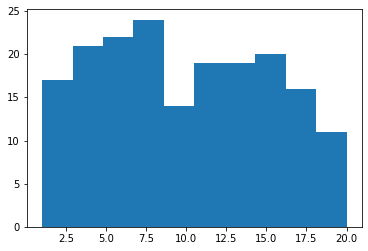

Total empty records: 183
Ratio empty/total: 0.07682619647355164


In [15]:
plt.hist(train_data['Empty_count'][train_data['Empty_count'] != 0])
plt.show()
print('Total empty records:', sum(train_data['has_empty']))
print('Ratio empty/total:', sum(train_data['has_empty'])/train_data.shape[0])

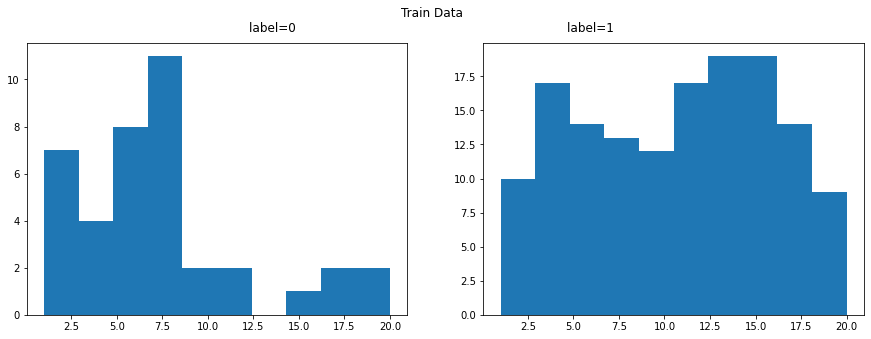

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Train Data\nlabel=0                                                                      label=1')
axs[0].hist(train_data['Empty_count'][(train_data['Empty_count'] != 0) & (train_data['label_original'] == -1)])
axs[1].hist(train_data['Empty_count'][(train_data['Empty_count'] != 0) & (train_data['label_original'] == 1)])
plt.show()

In [17]:
train_data.groupby(["label_original"]).sum().filter(['has_empty']).reset_index()

,label_original,has_empty
0,-1,39
1,1,144


### independent

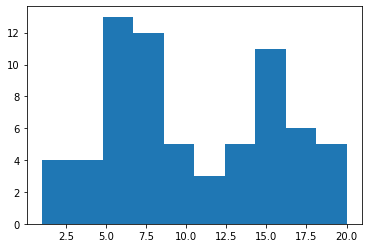

Total empty records: 68
Ratio empty/total: 0.05551020408163265


In [18]:
plt.hist(indpe_data['Empty_count'][indpe_data['Empty_count'] != 0])
plt.show()
print('Total empty records:', sum(indpe_data['has_empty']))
print('Ratio empty/total:', sum(indpe_data['has_empty'])/indpe_data.shape[0])

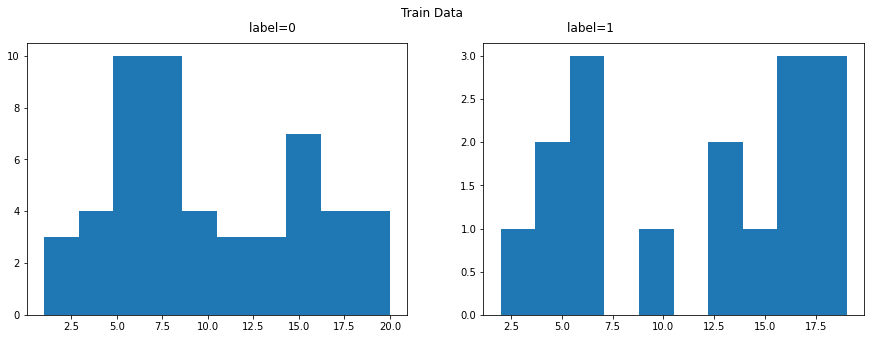

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Train Data\nlabel=0                                                                      label=1')
axs[0].hist(indpe_data['Empty_count'][(indpe_data['Empty_count'] != 0) & (indpe_data['label_original'] == -1)])
axs[1].hist(indpe_data['Empty_count'][(indpe_data['Empty_count'] != 0) & (indpe_data['label_original'] == 1)])
plt.show()

In [20]:
indpe_data.groupby(["label_original"]).sum().filter(['has_empty'])

,has_empty
label_original,
-1,52
1,16


In [21]:
_,_ = print_and_get_stats(train_data, indpe_data)

Current train_label_nonempty_ratio: 0.2708333333333333 train_label_ratio: 1.0
Target indpe_label_nonempty_ratio: 3.25 indpe_label_ratio: 5.0344827586206895


# Data Augmentation on Training dataset

In [22]:
import random

def sequence_truncate(seq, random_length):
    rep_str = "".join(['-']*random_length)
    if np.random.choice((True, False)):
        return_seq = rep_str + seq[random_length:]
    else:
        return_seq = seq[:-random_length] + rep_str
    return return_seq

def random_sequence_truncate(seq):
    random_length = np.random.randint(1, 20)
    return_seq = sequence_truncate(seq, random_length)
    return return_seq

def repeat_truncate_sequence_steps(seq, factor):
    random_length = random.sample(range(1, int(len(seq)/2)), 
                                  factor)
    return_seqs = []
    for i in range(factor):
        ret_seq = sequence_truncate(seq, random_length[i])
        return_seqs.append(ret_seq)
    return return_seqs

def truncate_sequence_by_len(seq, ran_len):
    return_seqs = []
    ret_seq = sequence_truncate(seq, ran_len)
    return ret_seq

In [23]:
def print_and_get_stats(source_data, target_data):
    
    # empty char count per sequence
    source_data['Empty_count'] = [np.sum(np.array(list(val)) == '-') for val in source_data['Sequence']]
    # incomplete sequence flag
    source_data['has_empty'] = [True if np.sum(np.array(list(val)) == '-') > 0 else False for val in source_data['Sequence']]
    
    target_data['Empty_count'] = [np.sum(np.array(list(val)) == '-') for val in target_data['Sequence']]
    target_data['has_empty'] = [True if np.sum(np.array(list(val)) == '-') > 0 else False for val in target_data['Sequence']]

    # 0:1
    train_label_nonempty_ratio = source_data.groupby(["label_original"]).sum().filter(['has_empty']).reset_index()['has_empty'][0] / source_data.groupby(["label_original"]).sum().filter(['has_empty']).reset_index()['has_empty'][1]
    train_label_ratio = (source_data.shape[0]-sum(source_data["label_original"] == 1)) / sum(source_data["label_original"] == 1)

    # 0:1
    indpe_label_nonempty_ratio = target_data.groupby(["label_original"]).sum().filter(['has_empty']).reset_index()['has_empty'][0] / target_data.groupby(["label_original"]).sum().filter(['has_empty']).reset_index()['has_empty'][1]
    indpe_label_ratio = (target_data.shape[0]-sum(target_data["label_original"] == 1)) / sum(target_data["label_original"] == 1)

    print('Current train_label_nonempty_ratio:', train_label_nonempty_ratio, 'train_label_ratio:', train_label_ratio)
    print('Target indpe_label_nonempty_ratio:', indpe_label_nonempty_ratio, 'indpe_label_ratio:', indpe_label_ratio)

    increase_0_data_factor = int(round(indpe_label_ratio/train_label_ratio)) - 1
    increase_empty_data_factor = int(round(indpe_label_nonempty_ratio/train_label_nonempty_ratio)) - 1
    
    return increase_0_data_factor, increase_empty_data_factor

In [24]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt

hist, bins = np.histogram(indpe_data['Empty_count'][indpe_data['Empty_count'] != 0], bins=10)

bin_midpoints = bins[:-1] + np.diff(bins)/2
cdf = np.cumsum(hist)
cdf = cdf / cdf[-1]
values = np.random.rand(100)
value_bins = np.searchsorted(cdf, values)
random_from_cdf = bin_midpoints[value_bins]

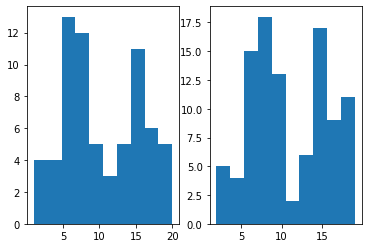

In [25]:
plt.subplot(121)
plt.hist(indpe_data['Empty_count'][indpe_data['Empty_count'] != 0], 10)
plt.subplot(122)
plt.hist(np.round(random_from_cdf).astype(int), 10)
plt.show()

In [26]:
# before balancing

# train_data = train_data_backup

########

factor = 1

data = train_data
neg_data = data[data['label_original'] == -1].reset_index(drop=True)
pos_data = data[data['label_original'] == 1].reset_index(drop=True)
# neg_data = data.reset_index(drop=True)

not_empty_neg_idxs = np.where(neg_data['has_empty'] != True)[0]
not_empty_pos_idxs = np.where(pos_data['has_empty'] != True)[0]
not_empty_pos_idxs = np.random.permutation(not_empty_pos_idxs)[0:int(not_empty_neg_idxs.shape[0]/factor)]

##### Getting missing distribution
hist, bins = np.histogram(indpe_data['Empty_count'][indpe_data['Empty_count'] != 0], bins=20)
bin_midpoints = bins[:-1] + np.diff(bins)/2
cdf = np.cumsum(hist)
cdf = cdf / cdf[-1]

##### Negative records augmentation
neg_values = np.random.rand(not_empty_neg_idxs.shape[0])
neg_value_bins = np.searchsorted(cdf, neg_values)
neg_random_from_cdf = bin_midpoints[neg_value_bins]
neg_random_from_cdf = np.round(neg_random_from_cdf).astype(int)

for idx, ran_len in zip(list(not_empty_neg_idxs), list(list(neg_random_from_cdf))):
    record = neg_data.iloc[idx].to_dict()
    seq = truncate_sequence_by_len(record['Sequence'], ran_len)
    record['Sequence'] = seq
    neg_data = neg_data.append(record, ignore_index=True)

##### Positive records augmentation
pos_values = np.random.rand(not_empty_pos_idxs.shape[0])
pos_value_bins = np.searchsorted(cdf, pos_values)
pos_random_from_cdf = bin_midpoints[pos_value_bins]
pos_random_from_cdf = np.round(pos_random_from_cdf).astype(int)
    
for idx, ran_len in zip(list(not_empty_pos_idxs), list(list(pos_random_from_cdf))):
    record = pos_data.iloc[idx].to_dict()
    seq = truncate_sequence_by_len(record['Sequence'], ran_len)
    record['Sequence'] = seq
    pos_data = pos_data.append(record, ignore_index=True)
    
#     seqs = repeat_truncate_sequence_steps(record['Sequence'], factor)
#     for seq in seqs:
#         record['Sequence'] = seq
#         neg_data = neg_data.append(record, ignore_index=True)

final_data = pd.concat((neg_data, pos_data, data))
print(final_data.shape)

##########################

_ , _ = print_and_get_stats(final_data, indpe_data)

##########################

final_data = final_data.drop_duplicates().reset_index(drop=True)
print(final_data.shape)

print('\n##### After removing duplicates #####\n')
##########

_ , _ = print_and_get_stats(final_data, indpe_data)

(6963, 8)
Current train_label_nonempty_ratio: 0.9213483146067416 train_label_ratio: 1.0306211723534557
Target indpe_label_nonempty_ratio: 3.25 indpe_label_ratio: 5.0344827586206895
(4581, 8)

##### After removing duplicates #####

Current train_label_nonempty_ratio: 1.0 train_label_ratio: 1.0469168900804289
Target indpe_label_nonempty_ratio: 3.25 indpe_label_ratio: 5.0344827586206895


In [27]:
# # after balancing

# # train_data = train_data_backup

# ########

# factor = 3

# data = train_data
# neg_data = data[data['label_original'] == -1].reset_index(drop=True)
# pos_data = data[data['label_original'] == 1].reset_index(drop=True)
# # neg_data = data.reset_index(drop=True)

# not_empty_neg_idxs = np.where(neg_data['has_empty'] != True)[0]
# not_empty_pos_idxs = np.where(pos_data['has_empty'] != True)[0]
# not_empty_pos_idxs = np.random.permutation(not_empty_pos_idxs)[0:int(not_empty_neg_idxs.shape[0]/factor)]
# not_empty_neg_idxs = np.random.permutation(not_empty_neg_idxs)[0:int(not_empty_pos_idxs.shape[0]/factor)]


# ##### Getting missing distribution
# hist, bins = np.histogram(indpe_data['Empty_count'][indpe_data['Empty_count'] != 0], bins=20)
# bin_midpoints = bins[:-1] + np.diff(bins)/2
# cdf = np.cumsum(hist)
# cdf = cdf / cdf[-1]

# ##### Negative records augmentation
# neg_values = np.random.rand(not_empty_neg_idxs.shape[0])
# neg_value_bins = np.searchsorted(cdf, neg_values)
# neg_random_from_cdf = bin_midpoints[neg_value_bins]
# neg_random_from_cdf = np.round(neg_random_from_cdf).astype(int)

# for idx, ran_len in zip(list(not_empty_neg_idxs), list(list(neg_random_from_cdf))):
#     record = neg_data.iloc[idx].to_dict()
#     seq = truncate_sequence_by_len(record['Sequence'], ran_len)
#     record['Sequence'] = seq
#     neg_data = neg_data.append(record, ignore_index=True)

# ##### Positive records augmentation
# pos_values = np.random.rand(not_empty_pos_idxs.shape[0])
# pos_value_bins = np.searchsorted(cdf, pos_values)
# pos_random_from_cdf = bin_midpoints[pos_value_bins]
# pos_random_from_cdf = np.round(pos_random_from_cdf).astype(int)
    
# for idx, ran_len in zip(list(not_empty_pos_idxs), list(list(pos_random_from_cdf))):
#     record = pos_data.iloc[idx].to_dict()
#     seq = truncate_sequence_by_len(record['Sequence'], ran_len)
#     record['Sequence'] = seq
#     pos_data = pos_data.append(record, ignore_index=True)
    
# #     seqs = repeat_truncate_sequence_steps(record['Sequence'], factor)
# #     for seq in seqs:
# #         record['Sequence'] = seq
# #         neg_data = neg_data.append(record, ignore_index=True)

# final_data = pd.concat((neg_data, pos_data, data))
# print(final_data.shape)

# ##########################

# _ , _ = print_and_get_stats(final_data, indpe_data)

# ##########################

# final_data = final_data.drop_duplicates().reset_index(drop=True)
# print(final_data.shape)

# print('\n##### After removing duplicates #####\n')
# ##########

# _ , _ = print_and_get_stats(final_data, indpe_data)

In [28]:
# empty char count per sequence
final_data['Empty_count'] = [np.sum(np.array(list(val)) == '-') for val in final_data['Sequence']]
# incomplete sequence flag
final_data['has_empty'] = [True if np.sum(np.array(list(val)) == '-') > 0 else False for val in final_data['Sequence']]

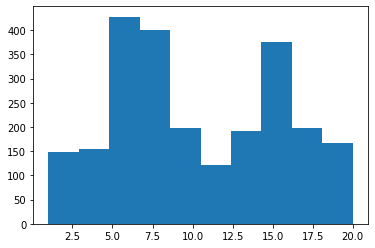

Total empty records: 2382
Ratio empty/total: 0.5199738048461034


In [29]:
plt.hist(final_data['Empty_count'][final_data['Empty_count'] != 0])
plt.show()
print('Total empty records:', sum(final_data['has_empty']))
print('Ratio empty/total:', sum(final_data['has_empty'])/final_data.shape[0])

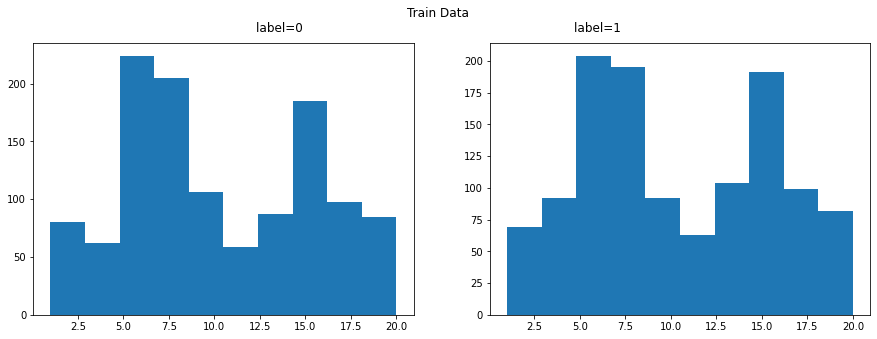

In [30]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Train Data\nlabel=0                                                                      label=1')
axs[0].hist(final_data['Empty_count'][(final_data['Empty_count'] != 0) & (final_data['label_original'] == -1)])
axs[1].hist(final_data['Empty_count'][(final_data['Empty_count'] != 0) & (final_data['label_original'] == 1)])
plt.show()

In [31]:
final_data.groupby(["label_original"]).sum().filter(['has_empty']).reset_index()

,label_original,has_empty
0,-1,1191
1,1,1191


##  Final preparations for training data

In [32]:
train_data = final_data

##################################################################################
##### Create dictionary of all characters in the NT sequence 
##################################################################################
all_char_set = set({})
for val in [set(val) for val in train_data['Sequence']]:
    all_char_set = all_char_set.union(val)
all_char_list = list(all_char_set)
all_char_list.sort()
all_char_dict = {}
for i in range(len(all_char_list)):
    all_char_dict[all_char_list[i]] = i
    
##################################################################################
##### Create OHE of sequence
##################################################################################
train_data['OHE_Sequence'] = pd.Series([one_hot_encode_nt(val, all_char_dict) 
                                        for val in train_data["Sequence"]])

##################################################################################
##### Fix the labels
##################################################################################
train_data['label'] = pd.Series([1 if val == 1 else 0 
                                 for val in train_data["label_original"]])

##################################################################################
##### Extract features and labels, create folds
##################################################################################

train_features = np.array(list(train_data['OHE_Sequence']))
train_labels = np.array(list(train_data['label']))
train_labels = train_labels.reshape((train_labels.shape[0], 1))

input_seq_shape = train_features[0].shape

folds = build_kfold(train_features, train_labels, k=n_fold, shuffle=shuffle, seed=seed)

## Write the k-fold dataset to file
foldPath = os.path.join(outPath, expName, "{}fold".format(n_fold))
if(not os.path.isdir(foldPath)):
    os.makedirs(foldPath)
pickle.dump(folds, open(os.path.join(foldPath, foldName), "wb"))

# Final prep for Independent dataset

In [33]:
##################################################################################
##### Create OHE of sequence
##################################################################################
indpe_data['OHE_Sequence'] = pd.Series([one_hot_encode_nt(val, all_char_dict) 
                                        for val in indpe_data["Sequence"]])

##################################################################################
##### Fix the labels
##################################################################################
indpe_data['label'] = pd.Series([1 if val == 1 else 0 
                                 for val in indpe_data["label_original"]])

##################################################################################
##### Extract features and labels, create folds
##################################################################################

indpe_features = np.array(list(indpe_data['OHE_Sequence']))
indpe_labels = np.array(list(indpe_data['label']))
indpe_labels = indpe_labels.reshape((indpe_labels.shape[0], 1))

input_seq_shape = indpe_features[0].shape

In [34]:
input_seq_shape

(41, 21)

# Training

In [35]:
##################################################################################
##### For each input file, train model and generate different outputs in a structured folder
##################################################################################

## create the evaluation data structure for all iterations
evaluations = {
    "Fold" : [],
    "Train_Test" : [],
    "Accuracy" : [],
    "Precision": [],
    "TPR": [],
    "FPR": [],
    "TPR_FPR_Thresholds": [],
    "AUC": [],
    "Sensitivity": [],
    "Specificity": [],
    "MCC":[]
}

##################################################################################
##### Train/Test model on all folds, generate evaluations
##################################################################################

## Create and set directory to save model
modelPath = os.path.join(outPath, expName, "{}fold".format(n_fold), "models")
if(not os.path.isdir(modelPath)):
    os.makedirs(modelPath)

i = -1
for fold in folds:
    i += 1
    
    print("\nTrain/Test model on Fold #"+str(i)+".")
    
    model = DLNN_CORENup(input_seq_shape = input_seq_shape)
    
    ## Define the model callbacks for early stopping and saving the model. Then train model
    current_model_path = os.path.join(modelPath, "bestModel-fold{}.hdf5".format(i))
    modelCallbacks = [
        tf.keras.callbacks.ModelCheckpoint(current_model_path,
                                           monitor = 'val_loss', verbose = 1, save_best_only = True, 
                                           save_weights_only = False, mode = 'auto', save_freq = 'epoch'),
    ]
    
    # adding random shuffling of the dataset for training purpose
    index_arr = np.arange(fold["X_train"].shape[0])
    index_arr = np.random.permutation(index_arr)
    
    model.fit(x = fold["X_train"][index_arr], y = fold["y_train"][index_arr], batch_size = batch_size, epochs = epochs, verbose = 1, 
              callbacks = modelCallbacks, validation_data = (fold["X_test"], fold["y_test"]))
    
    model = tf.keras.models.load_model(current_model_path)
    
    ##################################################################################
    ##### Prediction and metrics for TRAIN dataset
    ##################################################################################

    y_pred = model.predict(fold["X_train"])
    label_pred = pred2label(y_pred)
    
    # Compute precision, recall, sensitivity, specifity, mcc
    acc = accuracy_score(fold["y_train"], label_pred)
    prec = precision_score(fold["y_train"],label_pred)
    mcc = matthews_corrcoef(fold["y_train"], label_pred)

    conf = confusion_matrix(fold["y_train"], label_pred)
    tn, fp, fn, tp = conf.ravel()
    sens = tp/(tp+fn)
    spec = tn/(tn+fp)

    fpr, tpr, thresholds = roc_curve(fold["y_train"], y_pred)
    auc = roc_auc_score(fold["y_train"], y_pred)
    
    evaluations["Fold"].append(i)
    evaluations["Train_Test"].append("Train")
    evaluations["Accuracy"].append(acc)
    evaluations["Precision"].append(prec)
    evaluations["TPR"].append(tpr)
    evaluations["FPR"].append(fpr)
    evaluations["TPR_FPR_Thresholds"].append(thresholds)
    evaluations["AUC"].append(auc)
    evaluations["Sensitivity"].append(sens)
    evaluations["Specificity"].append(spec)
    evaluations["MCC"].append(mcc)
    
    ##################################################################################
    ##### Prediction and metrics for TEST dataset
    ##################################################################################

    y_pred = model.predict(fold["X_test"])
    label_pred = pred2label(y_pred)
    
    # Compute precision, recall, sensitivity, specifity, mcc
    acc = accuracy_score(fold["y_test"], label_pred)
    prec = precision_score(fold["y_test"],label_pred)
    mcc = matthews_corrcoef(fold["y_test"], label_pred)

    conf = confusion_matrix(fold["y_test"], label_pred)
    tn, fp, fn, tp = conf.ravel()
    sens = tp/(tp+fn)
    spec = tn/(tn+fp)

    fpr, tpr, thresholds = roc_curve(fold["y_test"], y_pred)
    auc = roc_auc_score(fold["y_test"], y_pred)
    
    evaluations["Fold"].append(i)
    evaluations["Train_Test"].append("Test")
    evaluations["Accuracy"].append(acc)
    evaluations["Precision"].append(prec)
    evaluations["TPR"].append(tpr)
    evaluations["FPR"].append(fpr)
    evaluations["TPR_FPR_Thresholds"].append(thresholds)
    evaluations["AUC"].append(auc)
    evaluations["Sensitivity"].append(sens)
    evaluations["Specificity"].append(spec)
    evaluations["MCC"].append(mcc)


Train/Test model on Fold #0.
Epoch 1/100
58/58 [==============================] - ETA: 0s - loss: 1.3736
Epoch 1: val_loss improved from inf to 1.27744, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_TrainStrat_2_mySOTA\5fold\models\bestModel-fold0.hdf5
58/58 [==============================] - 5s 19ms/step - loss: 1.3736 - val_loss: 1.2774
Epoch 2/100
58/58 [==============================] - ETA: 0s - loss: 1.2160
Epoch 2: val_loss improved from 1.27744 to 1.13120, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_TrainStrat_2_mySOTA\5fold\models\bestModel-fold0.hdf5
58/58 [==============================] - 1s 11ms/step - loss: 1.2160 - val_loss: 1.1312
Epoch 3/100
54/58 [==========================>...] - ETA: 0s - loss: 1.0912
Epoch 3: val_loss improved from 1.13120 to 0.99187, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_TrainStrat_2_mySOTA\5fold\models\bestModel-fold0.hdf5
58/58 [==============================] 

57/58 [============================>.] - ETA: 0s - loss: 0.5421
Epoch 26: val_loss improved from 0.55325 to 0.53720, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_TrainStrat_2_mySOTA\5fold\models\bestModel-fold0.hdf5
58/58 [==============================] - 1s 9ms/step - loss: 0.5426 - val_loss: 0.5372
Epoch 27/100
58/58 [==============================] - ETA: 0s - loss: 0.5279
Epoch 27: val_loss improved from 0.53720 to 0.52649, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_TrainStrat_2_mySOTA\5fold\models\bestModel-fold0.hdf5
58/58 [==============================] - 1s 10ms/step - loss: 0.5279 - val_loss: 0.5265
Epoch 28/100
58/58 [==============================] - ETA: 0s - loss: 0.5221
Epoch 28: val_loss improved from 0.52649 to 0.51993, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_TrainStrat_2_mySOTA\5fold\models\bestModel-fold0.hdf5
58/58 [==============================] - 1s 10ms/step - loss: 0.5221 - va

Epoch 53/100
57/58 [============================>.] - ETA: 0s - loss: 0.3942
Epoch 53: val_loss did not improve from 0.42446
58/58 [==============================] - 0s 9ms/step - loss: 0.3936 - val_loss: 0.4297
Epoch 54/100
57/58 [============================>.] - ETA: 0s - loss: 0.3817
Epoch 54: val_loss did not improve from 0.42446
58/58 [==============================] - 1s 9ms/step - loss: 0.3815 - val_loss: 0.4253
Epoch 55/100
57/58 [============================>.] - ETA: 0s - loss: 0.3875
Epoch 55: val_loss improved from 0.42446 to 0.42373, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_TrainStrat_2_mySOTA\5fold\models\bestModel-fold0.hdf5
58/58 [==============================] - 1s 9ms/step - loss: 0.3883 - val_loss: 0.4237
Epoch 56/100
58/58 [==============================] - ETA: 0s - loss: 0.3838
Epoch 56: val_loss did not improve from 0.42373
58/58 [==============================] - 0s 9ms/step - loss: 0.3838 - val_loss: 0.4374
Epoch 57/100
52/58 [==

54/58 [==========================>...] - ETA: 0s - loss: 0.3114
Epoch 84: val_loss improved from 0.38637 to 0.37806, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_TrainStrat_2_mySOTA\5fold\models\bestModel-fold0.hdf5
58/58 [==============================] - 1s 10ms/step - loss: 0.3127 - val_loss: 0.3781
Epoch 85/100
57/58 [============================>.] - ETA: 0s - loss: 0.3218
Epoch 85: val_loss did not improve from 0.37806
58/58 [==============================] - 1s 10ms/step - loss: 0.3217 - val_loss: 0.3921
Epoch 86/100
54/58 [==========================>...] - ETA: 0s - loss: 0.3219
Epoch 86: val_loss did not improve from 0.37806
58/58 [==============================] - 1s 10ms/step - loss: 0.3252 - val_loss: 0.3969
Epoch 87/100
53/58 [==========================>...] - ETA: 0s - loss: 0.3070
Epoch 87: val_loss did not improve from 0.37806
58/58 [==============================] - 1s 10ms/step - loss: 0.3040 - val_loss: 0.3832
Epoch 88/100
55/58 [===========

58/58 [==============================] - 1s 10ms/step - loss: 0.6817 - val_loss: 0.6852
Epoch 13/100
53/58 [==========================>...] - ETA: 0s - loss: 0.6694
Epoch 13: val_loss improved from 0.68518 to 0.66893, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_TrainStrat_2_mySOTA\5fold\models\bestModel-fold1.hdf5
58/58 [==============================] - 1s 10ms/step - loss: 0.6718 - val_loss: 0.6689
Epoch 14/100
55/58 [===========================>..] - ETA: 0s - loss: 0.6578
Epoch 14: val_loss improved from 0.66893 to 0.65928, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_TrainStrat_2_mySOTA\5fold\models\bestModel-fold1.hdf5
58/58 [==============================] - 1s 10ms/step - loss: 0.6575 - val_loss: 0.6593
Epoch 15/100
54/58 [==========================>...] - ETA: 0s - loss: 0.6326
Epoch 15: val_loss improved from 0.65928 to 0.64412, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_TrainStrat_2_mySOTA\5fold

56/58 [===========================>..] - ETA: 0s - loss: 0.4545
Epoch 37: val_loss did not improve from 0.49522
58/58 [==============================] - 1s 9ms/step - loss: 0.4535 - val_loss: 0.5054
Epoch 38/100
54/58 [==========================>...] - ETA: 0s - loss: 0.4421
Epoch 38: val_loss improved from 0.49522 to 0.48790, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_TrainStrat_2_mySOTA\5fold\models\bestModel-fold1.hdf5
58/58 [==============================] - 1s 10ms/step - loss: 0.4411 - val_loss: 0.4879
Epoch 39/100
56/58 [===========================>..] - ETA: 0s - loss: 0.4343
Epoch 39: val_loss did not improve from 0.48790
58/58 [==============================] - 1s 9ms/step - loss: 0.4342 - val_loss: 0.5021
Epoch 40/100
55/58 [===========================>..] - ETA: 0s - loss: 0.4379
Epoch 40: val_loss did not improve from 0.48790
58/58 [==============================] - 1s 9ms/step - loss: 0.4368 - val_loss: 0.5002
Epoch 41/100
56/58 [==============

56/58 [===========================>..] - ETA: 0s - loss: 0.3579
Epoch 67: val_loss improved from 0.41565 to 0.41208, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_TrainStrat_2_mySOTA\5fold\models\bestModel-fold1.hdf5
58/58 [==============================] - 1s 10ms/step - loss: 0.3571 - val_loss: 0.4121
Epoch 68/100
54/58 [==========================>...] - ETA: 0s - loss: 0.3393
Epoch 68: val_loss improved from 0.41208 to 0.40596, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_TrainStrat_2_mySOTA\5fold\models\bestModel-fold1.hdf5
58/58 [==============================] - 1s 10ms/step - loss: 0.3407 - val_loss: 0.4060
Epoch 69/100
53/58 [==========================>...] - ETA: 0s - loss: 0.3524
Epoch 69: val_loss did not improve from 0.40596
58/58 [==============================] - 1s 10ms/step - loss: 0.3501 - val_loss: 0.4119
Epoch 70/100
54/58 [==========================>...] - ETA: 0s - loss: 0.3440
Epoch 70: val_loss improved from 0.40

58/58 [==============================] - 1s 10ms/step - loss: 0.2997 - val_loss: 0.3684
Epoch 100/100
55/58 [===========================>..] - ETA: 0s - loss: 0.2890
Epoch 100: val_loss improved from 0.36840 to 0.36286, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_TrainStrat_2_mySOTA\5fold\models\bestModel-fold1.hdf5
58/58 [==============================] - 1s 10ms/step - loss: 0.2902 - val_loss: 0.3629

Train/Test model on Fold #2.
Epoch 1/100
54/58 [==========================>...] - ETA: 0s - loss: 1.3812
Epoch 1: val_loss improved from inf to 1.29077, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_TrainStrat_2_mySOTA\5fold\models\bestModel-fold2.hdf5
58/58 [==============================] - 3s 18ms/step - loss: 1.3765 - val_loss: 1.2908
Epoch 2/100
54/58 [==========================>...] - ETA: 0s - loss: 1.2340
Epoch 2: val_loss improved from 1.29077 to 1.15051, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_T

58/58 [==============================] - 1s 10ms/step - loss: 0.5287 - val_loss: 0.5769
Epoch 25/100
58/58 [==============================] - ETA: 0s - loss: 0.5227
Epoch 25: val_loss improved from 0.57693 to 0.57525, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_TrainStrat_2_mySOTA\5fold\models\bestModel-fold2.hdf5
58/58 [==============================] - 1s 10ms/step - loss: 0.5227 - val_loss: 0.5752
Epoch 26/100
55/58 [===========================>..] - ETA: 0s - loss: 0.5093
Epoch 26: val_loss improved from 0.57525 to 0.56812, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_TrainStrat_2_mySOTA\5fold\models\bestModel-fold2.hdf5
58/58 [==============================] - 1s 10ms/step - loss: 0.5095 - val_loss: 0.5681
Epoch 27/100
56/58 [===========================>..] - ETA: 0s - loss: 0.5047
Epoch 27: val_loss improved from 0.56812 to 0.56646, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_TrainStrat_2_mySOTA\5fold

58/58 [==============================] - 1s 10ms/step - loss: 0.3688 - val_loss: 0.4814
Epoch 54/100
55/58 [===========================>..] - ETA: 0s - loss: 0.3617
Epoch 54: val_loss improved from 0.48142 to 0.47858, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_TrainStrat_2_mySOTA\5fold\models\bestModel-fold2.hdf5
58/58 [==============================] - 1s 10ms/step - loss: 0.3638 - val_loss: 0.4786
Epoch 55/100
54/58 [==========================>...] - ETA: 0s - loss: 0.3709
Epoch 55: val_loss improved from 0.47858 to 0.47847, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_TrainStrat_2_mySOTA\5fold\models\bestModel-fold2.hdf5
58/58 [==============================] - 1s 10ms/step - loss: 0.3710 - val_loss: 0.4785
Epoch 56/100
57/58 [============================>.] - ETA: 0s - loss: 0.3693
Epoch 56: val_loss improved from 0.47847 to 0.47214, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_TrainStrat_2_mySOTA\5fold

58/58 [==============================] - 1s 9ms/step - loss: 0.3098 - val_loss: 0.4428
Epoch 84/100
54/58 [==========================>...] - ETA: 0s - loss: 0.3027
Epoch 84: val_loss did not improve from 0.44024
58/58 [==============================] - 1s 9ms/step - loss: 0.3010 - val_loss: 0.4561
Epoch 85/100
56/58 [===========================>..] - ETA: 0s - loss: 0.3149
Epoch 85: val_loss improved from 0.44024 to 0.43460, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_TrainStrat_2_mySOTA\5fold\models\bestModel-fold2.hdf5
58/58 [==============================] - 1s 10ms/step - loss: 0.3139 - val_loss: 0.4346
Epoch 86/100
55/58 [===========================>..] - ETA: 0s - loss: 0.3008
Epoch 86: val_loss did not improve from 0.43460
58/58 [==============================] - 1s 9ms/step - loss: 0.3039 - val_loss: 0.4378
Epoch 87/100
57/58 [============================>.] - ETA: 0s - loss: 0.3061
Epoch 87: val_loss improved from 0.43460 to 0.43172, saving model to 

57/58 [============================>.] - ETA: 0s - loss: 0.7014
Epoch 12: val_loss improved from 0.69368 to 0.68491, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_TrainStrat_2_mySOTA\5fold\models\bestModel-fold3.hdf5
58/58 [==============================] - 1s 10ms/step - loss: 0.7022 - val_loss: 0.6849
Epoch 13/100
56/58 [===========================>..] - ETA: 0s - loss: 0.6871
Epoch 13: val_loss improved from 0.68491 to 0.66321, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_TrainStrat_2_mySOTA\5fold\models\bestModel-fold3.hdf5
58/58 [==============================] - 1s 10ms/step - loss: 0.6879 - val_loss: 0.6632
Epoch 14/100
55/58 [===========================>..] - ETA: 0s - loss: 0.6696
Epoch 14: val_loss improved from 0.66321 to 0.64699, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_TrainStrat_2_mySOTA\5fold\models\bestModel-fold3.hdf5
58/58 [==============================] - 1s 10ms/step - loss: 0.6669 - v

58/58 [==============================] - 1s 11ms/step - loss: 0.4703 - val_loss: 0.5009
Epoch 37/100
54/58 [==========================>...] - ETA: 0s - loss: 0.4552
Epoch 37: val_loss improved from 0.50090 to 0.48865, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_TrainStrat_2_mySOTA\5fold\models\bestModel-fold3.hdf5
58/58 [==============================] - 1s 10ms/step - loss: 0.4554 - val_loss: 0.4886
Epoch 38/100
58/58 [==============================] - ETA: 0s - loss: 0.4574
Epoch 38: val_loss did not improve from 0.48865
58/58 [==============================] - 1s 9ms/step - loss: 0.4574 - val_loss: 0.4999
Epoch 39/100
55/58 [===========================>..] - ETA: 0s - loss: 0.4575
Epoch 39: val_loss improved from 0.48865 to 0.48060, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_TrainStrat_2_mySOTA\5fold\models\bestModel-fold3.hdf5
58/58 [==============================] - 1s 10ms/step - loss: 0.4542 - val_loss: 0.4806
Epoch 40/100
5

Epoch 66/100
56/58 [===========================>..] - ETA: 0s - loss: 0.3482
Epoch 66: val_loss improved from 0.41454 to 0.41262, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_TrainStrat_2_mySOTA\5fold\models\bestModel-fold3.hdf5
58/58 [==============================] - 1s 10ms/step - loss: 0.3481 - val_loss: 0.4126
Epoch 67/100
54/58 [==========================>...] - ETA: 0s - loss: 0.3514
Epoch 67: val_loss improved from 0.41262 to 0.41173, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_TrainStrat_2_mySOTA\5fold\models\bestModel-fold3.hdf5
58/58 [==============================] - 1s 10ms/step - loss: 0.3530 - val_loss: 0.4117
Epoch 68/100
55/58 [===========================>..] - ETA: 0s - loss: 0.3551
Epoch 68: val_loss did not improve from 0.41173
58/58 [==============================] - 1s 9ms/step - loss: 0.3548 - val_loss: 0.4192
Epoch 69/100
55/58 [===========================>..] - ETA: 0s - loss: 0.3353
Epoch 69: val_loss did no

56/58 [===========================>..] - ETA: 0s - loss: 0.2994
Epoch 97: val_loss improved from 0.37781 to 0.37485, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_TrainStrat_2_mySOTA\5fold\models\bestModel-fold3.hdf5
58/58 [==============================] - 1s 10ms/step - loss: 0.2992 - val_loss: 0.3749
Epoch 98/100
56/58 [===========================>..] - ETA: 0s - loss: 0.2927
Epoch 98: val_loss did not improve from 0.37485
58/58 [==============================] - 1s 9ms/step - loss: 0.2924 - val_loss: 0.3775
Epoch 99/100
54/58 [==========================>...] - ETA: 0s - loss: 0.3061
Epoch 99: val_loss did not improve from 0.37485
58/58 [==============================] - 1s 10ms/step - loss: 0.3040 - val_loss: 0.3777
Epoch 100/100
55/58 [===========================>..] - ETA: 0s - loss: 0.2959
Epoch 100: val_loss improved from 0.37485 to 0.37430, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_TrainStrat_2_mySOTA\5fold\models\bestModel

55/58 [===========================>..] - ETA: 0s - loss: 0.5720
Epoch 22: val_loss improved from 0.58543 to 0.56859, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_TrainStrat_2_mySOTA\5fold\models\bestModel-fold4.hdf5
58/58 [==============================] - 1s 10ms/step - loss: 0.5699 - val_loss: 0.5686
Epoch 23/100
56/58 [===========================>..] - ETA: 0s - loss: 0.5471
Epoch 23: val_loss improved from 0.56859 to 0.56341, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_TrainStrat_2_mySOTA\5fold\models\bestModel-fold4.hdf5
58/58 [==============================] - 1s 10ms/step - loss: 0.5454 - val_loss: 0.5634
Epoch 24/100
58/58 [==============================] - ETA: 0s - loss: 0.5425
Epoch 24: val_loss improved from 0.56341 to 0.55667, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_TrainStrat_2_mySOTA\5fold\models\bestModel-fold4.hdf5
58/58 [==============================] - 1s 10ms/step - loss: 0.5425 - v

58/58 [==============================] - 1s 10ms/step - loss: 0.3936 - val_loss: 0.4410
Epoch 49/100
57/58 [============================>.] - ETA: 0s - loss: 0.3868
Epoch 49: val_loss did not improve from 0.44100
58/58 [==============================] - 1s 9ms/step - loss: 0.3873 - val_loss: 0.4451
Epoch 50/100
57/58 [============================>.] - ETA: 0s - loss: 0.3908
Epoch 50: val_loss improved from 0.44100 to 0.43889, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_TrainStrat_2_mySOTA\5fold\models\bestModel-fold4.hdf5
58/58 [==============================] - 1s 10ms/step - loss: 0.3911 - val_loss: 0.4389
Epoch 51/100
56/58 [===========================>..] - ETA: 0s - loss: 0.3926
Epoch 51: val_loss improved from 0.43889 to 0.43666, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_TrainStrat_2_mySOTA\5fold\models\bestModel-fold4.hdf5
58/58 [==============================] - 1s 10ms/step - loss: 0.3938 - val_loss: 0.4367
Epoch 52/100
5

56/58 [===========================>..] - ETA: 0s - loss: 0.3245
Epoch 79: val_loss improved from 0.39957 to 0.39766, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_TrainStrat_2_mySOTA\5fold\models\bestModel-fold4.hdf5
58/58 [==============================] - 1s 10ms/step - loss: 0.3245 - val_loss: 0.3977
Epoch 80/100
54/58 [==========================>...] - ETA: 0s - loss: 0.3163
Epoch 80: val_loss did not improve from 0.39766
58/58 [==============================] - 1s 9ms/step - loss: 0.3153 - val_loss: 0.4221
Epoch 81/100
57/58 [============================>.] - ETA: 0s - loss: 0.3191
Epoch 81: val_loss improved from 0.39766 to 0.39551, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_TrainStrat_2_mySOTA\5fold\models\bestModel-fold4.hdf5
58/58 [==============================] - 1s 11ms/step - loss: 0.3191 - val_loss: 0.3955
Epoch 82/100
57/58 [============================>.] - ETA: 0s - loss: 0.3058
Epoch 82: val_loss improved from 0.395

## k-fold Training evaluation

In [36]:
evaluations_df = pd.DataFrame.from_dict(evaluations)

evaluations_df_grouped = evaluations_df.groupby(["Train_Test"]).mean().filter(['Accuracy', 
                                                                               'Precision', 
                                                                               'AUC', 
                                                                               'Sensitivity', 
                                                                               'Specificity', 
                                                                               'MCC'])

evaluations_df_grouped

,Accuracy,Precision,AUC,Sensitivity,Specificity,MCC
Train_Test,,,,,,
Test,0.889545,0.882330,0.950555,0.893221,0.886045,0.779274
Train,0.989958,0.990168,0.999280,0.989276,0.990610,0.979915


In [37]:
evaluations_df[evaluations_df["Train_Test"] == "Test"]

,Fold,Train_Test,Accuracy,Precision,TPR,FPR,TPR_FPR_Thresholds,AUC,Sensitivity,Specificity,MCC
1,0,Test,0.885496,0.888889,"[0.0, 0.002232142857142857, 0.3147321428571428...","[0.0, 0.0, 0.0, 0.0021321961620469083, 0.00213...","[1.9999897, 0.99998975, 0.97669035, 0.9766491,...",0.955498,0.875000,0.895522,0.770882
3,1,Test,0.898472,0.889868,"[0.0, 0.0022371364653243847, 0.091722595078299...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.002132196162046908...","[1.9997444, 0.99974436, 0.9911056, 0.990776, 0...",0.956538,0.903803,0.893390,0.796994
5,2,Test,0.887555,0.865957,"[0.0, 0.0022371364653243847, 0.156599552572706...","[0.0, 0.0, 0.0, 0.0021321961620469083, 0.00213...","[1.9998047, 0.9998048, 0.98289615, 0.9827208, ...",0.938119,0.910515,0.865672,0.776229
7,3,Test,0.883188,0.878049,"[0.0, 0.002232142857142857, 0.2455357142857142...","[0.0, 0.0, 0.0, 0.002136752136752137, 0.002136...","[1.9999865, 0.9999865, 0.9845069, 0.9840381, 0...",0.952495,0.883929,0.882479,0.766314
9,4,Test,0.893013,0.888889,"[0.0, 0.002232142857142857, 0.1428571428571428...","[0.0, 0.0, 0.0, 0.002136752136752137, 0.002136...","[1.998975, 0.99897504, 0.98446345, 0.9840373, ...",0.950125,0.892857,0.893162,0.785952


# Independent data testing

## Using k-fold Models

### Performance of each k-fold model

In [38]:
## create the evaluation data structure for all iterations
evaluations = {
    "Fold" : [],
    "Train_Test" : [],
    "Accuracy" : [],
    "Precision": [],
    "TPR": [],
    "FPR": [],
    "TPR_FPR_Thresholds": [],
    "AUC": [],
    "Sensitivity": [],
    "Specificity": [],
    "MCC":[]
}

##################################################################################
##### Prediction and metrics for Independent dataset
##################################################################################

for i in range(n_fold):
    
    current_model_path = os.path.join(modelPath, "bestModel-fold{}.hdf5".format(i))
    model = tf.keras.models.load_model(current_model_path)

    y_pred = model.predict(indpe_features)
    label_pred = pred2label(y_pred)

    # Compute precision, recall, sensitivity, specifity, mcc
    acc = accuracy_score(indpe_labels, label_pred)
    prec = precision_score(indpe_labels,label_pred)
    mcc = matthews_corrcoef(indpe_labels, label_pred)

    conf = confusion_matrix(indpe_labels, label_pred)
    tn, fp, fn, tp = conf.ravel()
    sens = tp/(tp+fn)
    spec = tn/(tn+fp)

    fpr, tpr, thresholds = roc_curve(indpe_labels, y_pred)
    auc = roc_auc_score(indpe_labels, y_pred)

    evaluations["Fold"].append(i)
    evaluations["Train_Test"].append("Independent")
    evaluations["Accuracy"].append(acc)
    evaluations["Precision"].append(prec)
    evaluations["TPR"].append(tpr)
    evaluations["FPR"].append(fpr)
    evaluations["TPR_FPR_Thresholds"].append(thresholds)
    evaluations["AUC"].append(auc)
    evaluations["Sensitivity"].append(sens)
    evaluations["Specificity"].append(spec)
    evaluations["MCC"].append(mcc)

##################################################################################

evaluations_df = pd.DataFrame.from_dict(evaluations)

evaluations_df_grouped = evaluations_df.groupby(["Train_Test"]).mean().filter(['Accuracy', 
                                                                               'Precision', 
                                                                               'AUC', 
                                                                               'Sensitivity', 
                                                                               'Specificity', 
                                                                               'MCC'])

evaluations_df_grouped

,Accuracy,Precision,AUC,Sensitivity,Specificity,MCC
Train_Test,,,,,,
Independent,0.658122,0.26352,0.667463,0.590148,0.671624,0.201645


In [39]:
evaluations_df

,Fold,Train_Test,Accuracy,Precision,TPR,FPR,TPR_FPR_Thresholds,AUC,Sensitivity,Specificity,MCC
0,0,Independent,0.678367,0.275294,"[0.0, 0.0, 0.014778325123152709, 0.01477832512...","[0.0, 0.0009784735812133072, 0.000978473581213...","[1.9999896, 0.9999896, 0.999828, 0.99949074, 0...",0.665333,0.576355,0.698630,0.214804
1,1,Independent,0.672653,0.280973,"[0.0, 0.0, 0.009852216748768473, 0.00985221674...","[0.0, 0.0009784735812133072, 0.000978473581213...","[1.9996637, 0.9996637, 0.99943346, 0.999353, 0...",0.689120,0.625616,0.681996,0.237038
2,2,Independent,0.648980,0.252723,"[0.0, 0.0, 0.0049261083743842365, 0.0049261083...","[0.0, 0.0009784735812133072, 0.000978473581213...","[1.9996042, 0.9996043, 0.9995111, 0.998442, 0....",0.660291,0.571429,0.664384,0.181142
3,3,Independent,0.659592,0.266376,"[0.0, 0.0, 0.0, 0.014778325123152709, 0.014778...","[0.0, 0.0009784735812133072, 0.001956947162426...","[1.9999964, 0.9999964, 0.9998448, 0.9994086, 0...",0.675137,0.600985,0.671233,0.209199
4,4,Independent,0.631020,0.242236,"[0.0, 0.0, 0.0, 0.014778325123152709, 0.014778...","[0.0, 0.0009784735812133072, 0.001956947162426...","[1.9993458, 0.99934584, 0.99909437, 0.9975636,...",0.647431,0.576355,0.641879,0.166042


### Mean score with k-fold models

In [40]:
## create the evaluation data structure for all iterations
evaluations = {
    "Train_Test" : [],
    "Accuracy" : [],
    "Precision": [],
    "TPR": [],
    "FPR": [],
    "TPR_FPR_Thresholds": [],
    "AUC": [],
    "Sensitivity": [],
    "Specificity": [],
    "MCC":[]
}

##################################################################################
##### Prediction and metrics for Independent dataset
##################################################################################

total_pred = np.zeros(indpe_labels.shape)
all_preds = []

for i in range(n_fold):
    
    current_model_path = os.path.join(modelPath, "bestModel-fold{}.hdf5".format(i))
    model = tf.keras.models.load_model(current_model_path)

    y_pred = model.predict(indpe_features)
    total_pred += y_pred
    all_preds.append(y_pred)
    
total_pred = total_pred / n_fold
label_pred = pred2label(total_pred)

# Compute precision, recall, sensitivity, specifity, mcc
acc = accuracy_score(indpe_labels, label_pred)
prec = precision_score(indpe_labels,label_pred)
mcc = matthews_corrcoef(indpe_labels, label_pred)

conf = confusion_matrix(indpe_labels, label_pred)
tn, fp, fn, tp = conf.ravel()
sens = tp/(tp+fn)
spec = tn/(tn+fp)

fpr, tpr, thresholds = roc_curve(indpe_labels, total_pred)
auc = roc_auc_score(indpe_labels, total_pred)

evaluations["Train_Test"].append("Independent")
evaluations["Accuracy"].append(acc)
evaluations["Precision"].append(prec)
evaluations["TPR"].append(tpr)
evaluations["FPR"].append(fpr)
evaluations["TPR_FPR_Thresholds"].append(thresholds)
evaluations["AUC"].append(auc)
evaluations["Sensitivity"].append(sens)
evaluations["Specificity"].append(spec)
evaluations["MCC"].append(mcc)

##################################################################################

evaluations_df = pd.DataFrame.from_dict(evaluations)

evaluations_df_grouped = evaluations_df.groupby(["Train_Test"]).mean().filter(['Accuracy', 
                                                                               'Precision', 
                                                                               'AUC', 
                                                                               'Sensitivity', 
                                                                               'Specificity', 
                                                                               'MCC'])

evaluations_df_grouped

,Accuracy,Precision,AUC,Sensitivity,Specificity,MCC
Train_Test,,,,,,
Independent,0.669388,0.272523,0.675513,0.596059,0.683953,0.216587


### Voting score with k-fold models

In [41]:
## create the evaluation data structure for all iterations
evaluations = {
    "Train_Test" : [],
    "Accuracy" : [],
    "Precision": [],
    "TPR": [],
    "FPR": [],
    "TPR_FPR_Thresholds": [],
    "AUC": [],
    "Sensitivity": [],
    "Specificity": [],
    "MCC":[]
}

##################################################################################
##### Prediction and metrics for Independent dataset
##################################################################################

total_pred = np.zeros(indpe_labels.shape)
all_preds = []

for i in range(n_fold):
    
    current_model_path = os.path.join(modelPath, "bestModel-fold{}.hdf5".format(i))
    model = tf.keras.models.load_model(current_model_path)

    y_pred = model.predict(indpe_features)
    vote_pred = pred2label(y_pred)
    total_pred += vote_pred
    all_preds.append(vote_pred)
    
total_pred = total_pred / n_fold
label_pred = pred2label(total_pred)

# Compute precision, recall, sensitivity, specifity, mcc
acc = accuracy_score(indpe_labels, label_pred)
prec = precision_score(indpe_labels,label_pred)
mcc = matthews_corrcoef(indpe_labels, label_pred)

conf = confusion_matrix(indpe_labels, label_pred)
tn, fp, fn, tp = conf.ravel()
sens = tp/(tp+fn)
spec = tn/(tn+fp)

fpr, tpr, thresholds = roc_curve(indpe_labels, total_pred)
auc = roc_auc_score(indpe_labels, total_pred)

evaluations["Train_Test"].append("Independent")
evaluations["Accuracy"].append(acc)
evaluations["Precision"].append(prec)
evaluations["TPR"].append(tpr)
evaluations["FPR"].append(fpr)
evaluations["TPR_FPR_Thresholds"].append(thresholds)
evaluations["AUC"].append(auc)
evaluations["Sensitivity"].append(sens)
evaluations["Specificity"].append(spec)
evaluations["MCC"].append(mcc)

##################################################################################

evaluations_df = pd.DataFrame.from_dict(evaluations)

evaluations_df_grouped = evaluations_df.groupby(["Train_Test"]).mean().filter(['Accuracy', 
                                                                               'Precision', 
                                                                               'AUC', 
                                                                               'Sensitivity', 
                                                                               'Specificity', 
                                                                               'MCC'])

evaluations_df_grouped

,Accuracy,Precision,AUC,Sensitivity,Specificity,MCC
Train_Test,,,,,,
Independent,0.672653,0.276018,0.661904,0.600985,0.686888,0.222886


## Using New Model

Train model on full data from training. Predict and evaluate on Independent data.

In [42]:
epochs = 100
batch_size = 64


model = DLNN_CORENup(input_seq_shape = input_seq_shape,
                     metrics='accuracy')
    
## Define the model callbacks for early stopping and saving the model. Then train model
current_model_path = os.path.join(modelPath, "_fullModel.hdf5")
modelCallbacks = [
    tf.keras.callbacks.ModelCheckpoint(current_model_path,
                                       monitor = 'val_loss', verbose = 1, save_best_only = True, 
                                       save_weights_only = False, mode = 'auto', save_freq = 'epoch'),
]

# adding random shuffling of the dataset for training purpose
index_arr = np.arange(train_features.shape[0])
index_arr = np.random.permutation(index_arr)

model.fit(x = train_features[index_arr], y = train_labels[index_arr], 
          batch_size = batch_size, epochs = epochs, verbose = 1, 
          callbacks = modelCallbacks, validation_data = (indpe_features, indpe_labels))
# model.fit(x = train_features[index_arr], y = train_labels[index_arr], batch_size = batch_size, epochs = epochs, verbose = 1, 
#           callbacks = modelCallbacks, validation_split = 0.2)

model = tf.keras.models.load_model(current_model_path)

Epoch 1/100
72/72 [==============================] - ETA: 0s - loss: 1.3509 - accuracy: 0.5357
Epoch 1: val_loss improved from inf to 1.20870, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_TrainStrat_2_mySOTA\5fold\models\_fullModel.hdf5
72/72 [==============================] - 4s 21ms/step - loss: 1.3509 - accuracy: 0.5357 - val_loss: 1.2087 - val_accuracy: 0.7673
Epoch 2/100
67/72 [==========================>...] - ETA: 0s - loss: 1.1599 - accuracy: 0.6250
Epoch 2: val_loss improved from 1.20870 to 1.13297, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_TrainStrat_2_mySOTA\5fold\models\_fullModel.hdf5
72/72 [==============================] - 1s 11ms/step - loss: 1.1562 - accuracy: 0.6265 - val_loss: 1.1330 - val_accuracy: 0.6163
Epoch 3/100
67/72 [==========================>...] - ETA: 0s - loss: 1.0105 - accuracy: 0.6898
Epoch 3: val_loss improved from 1.13297 to 1.07713, saving model to Results\NT_Site_PredNTS_Classification_DLNN_COR

72/72 [==============================] - 1s 9ms/step - loss: 0.5227 - accuracy: 0.8031 - val_loss: 0.8603 - val_accuracy: 0.6237
Epoch 26/100
70/72 [============================>.] - ETA: 0s - loss: 0.5135 - accuracy: 0.8083
Epoch 26: val_loss did not improve from 0.73502
72/72 [==============================] - 1s 9ms/step - loss: 0.5130 - accuracy: 0.8081 - val_loss: 0.9464 - val_accuracy: 0.5665
Epoch 27/100
71/72 [============================>.] - ETA: 0s - loss: 0.4974 - accuracy: 0.8178
Epoch 27: val_loss improved from 0.73502 to 0.73260, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_TrainStrat_2_mySOTA\5fold\models\_fullModel.hdf5
72/72 [==============================] - 1s 10ms/step - loss: 0.4983 - accuracy: 0.8173 - val_loss: 0.7326 - val_accuracy: 0.7020
Epoch 28/100
70/72 [============================>.] - ETA: 0s - loss: 0.5001 - accuracy: 0.8136
Epoch 28: val_loss did not improve from 0.73260
72/72 [==============================] - 1s 9ms/step - 

68/72 [===========================>..] - ETA: 0s - loss: 0.3778 - accuracy: 0.8791
Epoch 55: val_loss did not improve from 0.73260
72/72 [==============================] - 1s 10ms/step - loss: 0.3759 - accuracy: 0.8806 - val_loss: 0.8344 - val_accuracy: 0.6857
Epoch 56/100
71/72 [============================>.] - ETA: 0s - loss: 0.3874 - accuracy: 0.8794
Epoch 56: val_loss did not improve from 0.73260
72/72 [==============================] - 1s 10ms/step - loss: 0.3883 - accuracy: 0.8791 - val_loss: 0.8917 - val_accuracy: 0.6718
Epoch 57/100
69/72 [===========================>..] - ETA: 0s - loss: 0.3650 - accuracy: 0.8897
Epoch 57: val_loss did not improve from 0.73260
72/72 [==============================] - 1s 10ms/step - loss: 0.3664 - accuracy: 0.8895 - val_loss: 0.8795 - val_accuracy: 0.6678
Epoch 58/100
70/72 [============================>.] - ETA: 0s - loss: 0.3545 - accuracy: 0.8862
Epoch 58: val_loss did not improve from 0.73260
72/72 [==============================] - 1s 10m

Epoch 85/100
67/72 [==========================>...] - ETA: 0s - loss: 0.3159 - accuracy: 0.9083
Epoch 85: val_loss did not improve from 0.73260
72/72 [==============================] - 1s 9ms/step - loss: 0.3177 - accuracy: 0.9070 - val_loss: 0.8665 - val_accuracy: 0.6922
Epoch 86/100
72/72 [==============================] - ETA: 0s - loss: 0.3100 - accuracy: 0.9155
Epoch 86: val_loss did not improve from 0.73260
72/72 [==============================] - 1s 10ms/step - loss: 0.3100 - accuracy: 0.9155 - val_loss: 1.0129 - val_accuracy: 0.6629
Epoch 87/100
71/72 [============================>.] - ETA: 0s - loss: 0.3100 - accuracy: 0.9126
Epoch 87: val_loss did not improve from 0.73260
72/72 [==============================] - 1s 10ms/step - loss: 0.3094 - accuracy: 0.9131 - val_loss: 0.9797 - val_accuracy: 0.6792
Epoch 88/100
68/72 [===========================>..] - ETA: 0s - loss: 0.3112 - accuracy: 0.9150
Epoch 88: val_loss did not improve from 0.73260
72/72 [============================

In [43]:
## create the evaluation data structure for all iterations
evaluations = {
    "Train_Test" : [],
    "Accuracy" : [],
    "Precision": [],
    "TPR": [],
    "FPR": [],
    "TPR_FPR_Thresholds": [],
    "AUC": [],
    "Sensitivity": [],
    "Specificity": [],
    "MCC":[]
}

##################################################################################
##### Prediction and metrics for Independent dataset
##################################################################################

y_pred = model.predict(indpe_features)
label_pred = pred2label(y_pred)

# Compute precision, recall, sensitivity, specifity, mcc
acc = accuracy_score(indpe_labels, label_pred)
prec = precision_score(indpe_labels,label_pred)
mcc = matthews_corrcoef(indpe_labels, label_pred)

conf = confusion_matrix(indpe_labels, label_pred)
tn, fp, fn, tp = conf.ravel()
sens = tp/(tp+fn)
spec = tn/(tn+fp)

fpr, tpr, thresholds = roc_curve(indpe_labels, y_pred)
auc = roc_auc_score(indpe_labels, y_pred)

evaluations["Train_Test"].append("Independent")
evaluations["Accuracy"].append(acc)
evaluations["Precision"].append(prec)
evaluations["TPR"].append(tpr)
evaluations["FPR"].append(fpr)
evaluations["TPR_FPR_Thresholds"].append(thresholds)
evaluations["AUC"].append(auc)
evaluations["Sensitivity"].append(sens)
evaluations["Specificity"].append(spec)
evaluations["MCC"].append(mcc)

##################################################################################

evaluations_df = pd.DataFrame.from_dict(evaluations)

evaluations_df_grouped = evaluations_df.groupby(["Train_Test"]).mean().filter(['Accuracy', 
                                                                               'Precision', 
                                                                               'AUC', 
                                                                               'Sensitivity', 
                                                                               'Specificity', 
                                                                               'MCC'])

evaluations_df_grouped

,Accuracy,Precision,AUC,Sensitivity,Specificity,MCC
Train_Test,,,,,,
Independent,0.702041,0.279891,0.672354,0.507389,0.740705,0.201222


In [44]:
# # after balancing the augmentation - large n/w - factor 3

# 	Accuracy	Precision	AUC	Sensitivity	Specificity	MCC
# Train_Test						
# Independent	0.68898	0.265789	0.680907	0.497537	0.727006	0.18049

In [45]:
# before balancing - large n/w - factor 3

# 	Accuracy	Precision	AUC	Sensitivity	Specificity	MCC
# Train_Test						
# Independent	0.733878	0.273063	0.666128	0.364532	0.807241	0.153875

# 	Accuracy	Precision	AUC	Sensitivity	Specificity	MCC
# Train_Test						
# Independent	0.715918	0.280967	0.673619	0.458128	0.767123	0.188607

In [46]:
print(classification_report(indpe_labels, np.round(y_pred).astype(int)))

              precision    recall  f1-score   support

           0       0.88      0.74      0.81      1022
           1       0.28      0.51      0.36       203

    accuracy                           0.70      1225
   macro avg       0.58      0.62      0.58      1225
weighted avg       0.78      0.70      0.73      1225



In [47]:
# after balancing the augmentation - large n/w - factor 3

#               precision    recall  f1-score   support

#            0       0.88      0.73      0.80      1022
#            1       0.27      0.50      0.35       203

#     accuracy                           0.69      1225
#    macro avg       0.57      0.61      0.57      1225
# weighted avg       0.78      0.69      0.72      1225

In [ ]:
# before balancing - large n/w - factor 3

# precision    recall  f1-score   support

#            0       0.88      0.75      0.81      1022
#            1       0.29      0.50      0.37       203

#     accuracy                           0.71      1225
#    macro avg       0.59      0.63      0.59      1225
# weighted avg       0.79      0.71      0.74      1225

# precision    recall  f1-score   support

#            0       0.86      0.81      0.84      1022
#            1       0.27      0.36      0.31       203

#     accuracy                           0.73      1225
#    macro avg       0.57      0.59      0.57      1225
# weighted avg       0.77      0.73      0.75      1225

In [49]:
np.sum(indpe_labels), np.sum(np.round(y_pred).astype(int))

(203, 368)

In [50]:
# (203, 331)